# Detección de "outliers" con el método z-score

En la lección anterior vimos cómo funciona el método de detección de "outliers" de Tukey, que en esencia es un método estadístico que hace uso del rango intercuartiles para determinar los umbrales que nos permitirán detectar los valores extremos.

Y este método es robusto pues funciona incluso cuando no tenemos una distribución Normal o Gaussiana en las observaciones.

En esta lección veremos el método z-score que permite detectar "outliers" cuando tenemos certeza de que la distribución de las observaciones en la Serie de Tiempo es Normal o Gaussiana.

Como veremos tiene un principio de funcionamiento muy similar al método de Tukey con la diferencia de que los umbrales se calcularán a partir de la media y la desviación estándar de las observaciones.

## 1. El método z-score para la detección de "outliers"

El método parte del hecho de que la distribución de los datos es Normal o Gaussiana (o es bastante cercana a esta distribución).

Y lo podemos resumir en 4 sencillos pasos:

1. Calcular la media ($\bar{x}$) y la desviación estándar ($s$) de las observaciones
2. Estandarizar cada observación para obtener su puntaje "z" (o *z-scores*):
$$z_i = \frac{x_i-\bar{x}}{s}$$
3. Definir los umbrales a partir de los cuales decidiremos si una observación es un "outlier". Las opciones más usadas son:
   - $z=\pm 3$ lo cual quiere decir que por debajo de 3 desviaciones estándar o por encima de 3 desviaciones estándar, con respecto a la media, tendremos un valor extremo. En este rango de valores tendremos tan sólo el 0.27% de los datos:
   
   ![](umbrales-3.png)
   - $z=\pm 2.5$ lo cual quiere decir que por debajo de 2.5 desviaciones estándar o por encima de 2.5 desviaciones estándar, con respecto a la media, tendremos un valor extremo. En este rango de valores tendremos tan sólo el 1.24% de los datos:
   
      ![](umbrales-2.5.png)

4. Los "outliers" serán las observaciones dentro de la Serie por debajo y por encima de los umbrales anteriores

Así que veamos de forma práctica cómo implementar este método.

## 3. Función auxiliar

Usaremos la misma función `graficar_outliers` de la lección anterior:

In [1]:
# Graficar outliers
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_outliers(serie, fechas, outliers=None):
    '''Graficar la Serie de Tiempo y superponer "outliers" de
    referencia y detectados.
    
    Parámetros:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    - fechas: listado de fechas con los "outliers" conocidos
    - outliers: los outliers detectados (DataFrame de Pandas)'''
    
    # Graficar la Serie de tiempo
    ax = serie.plot(alpha=0.7)
    
    # Superponer outliers de referencia
    serie.loc[fechas].plot(ax=ax, style='bo')
    
    # Superponer outliers detectados (si existen)
    if outliers is not None:
        outliers.plot(ax=ax, style='rx')
        plt.legend(['Serie de Tiempo', 'Outliers conocidos', 'Outliers detectados']);
    else:
        plt.legend(['Serie de Tiempo', 'Outliers conocidos'])
    
    # Ajustar etiquetas    
    plt.xlabel('Fecha')
    plt.ylabel('# pasajeros')    

## 3. El set de datos

Usaremos el mismo set de datos de la lección anterior (*taxis_ny.csv*) que contiene el número de pasajeros que han hecho uso del servicio de Taxis de la ciudad de Nueva York entre el 1 de julio de 2014 y el 31 de mayo de 2015.

Los datos han sido tomados con frecuencia de 30 minutos y en total se tienen 10.320 registros:

In [3]:
# Lectura del set de datos
import pandas as pd

RUTA = '../datasets/outliers/'

taxis_df = pd.read_csv(RUTA + 'taxis_ny.csv',
                    parse_dates = ['tiempo'],
                    index_col = ['tiempo'])
taxis_df

,obs
tiempo,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


Y creemos el listado con "outliers" conocidos:

In [4]:
# fechas con outliers conocidos
fechas =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

Como lo vimos en la lección anterior, la detección de valores extremos funciona mejor cuando remuestreamos la Serie a una frecuencia diaria:

In [5]:
# Remuestreo a frecuencia diaria
tx_diaria = taxis_df.resample('D').mean()
tx_diaria

,obs
tiempo,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


Y generemos el gráfico correspondiente (la Serie remuestreada y los valores extremos conocidos):

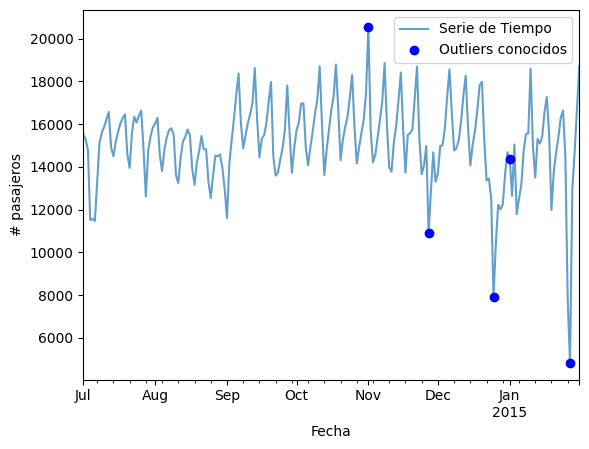

In [6]:
graficar_outliers(tx_diaria, fechas)

Perfecto, este es nuestro punto de partida. Ahora sí implementemos el método z-score

## 4. Implementación del método z-score

A continuación implementaremos una sencilla función (`outliers_zscore`) que permite realizar esta detección usando el método descrito anteriormente:

In [7]:
import numpy as np

def outliers_zscore(serie, umbral):
    '''Detecta los "outliers" en la Serie de Tiempo usando
    el método z-score.
    
    Entradas:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    - umbral: valor de z (positivo) a partir del cual se detectarán "outliers"
    
    Salida:
    - outliers: DataFrame de Pandas con los valores extremos detectados
    '''
    
    # 1,2 Calcular la media y la desviación de las observaciones y
    # estandarizar el resultado
    zs = (serie - serie.mean())/serie.std()
    
    # 4. Filtrar serie de tiempo para detectar los outliers
    outliers = serie[(zs.to_numpy() > umbral) | (zs.to_numpy() < -umbral)]
    
    return outliers

¡Y listo, con esta sencilla función ya hemos implementado el método z-score!

Pongámoslo a prueba con nuestra Serie de Tiempo remuestreada y con un umbral de 3 y además grafiquemos el resultado:

                    obs
tiempo                 
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667


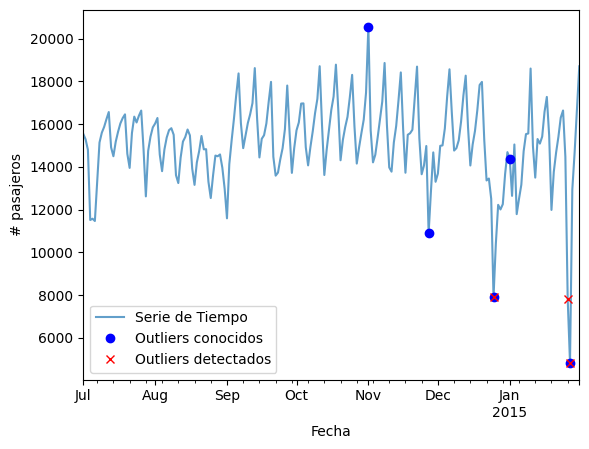

In [8]:
outliers = outliers_zscore(tx_diaria, umbral=3)
print(outliers)
graficar_outliers(tx_diaria, fechas, outliers)

En este caso el umbral es demasiado alto y se detectan 3 outliers, de los cuales 2 están en fechas muy cercanas (26 y 27 de enero de 2015).

Veamos qué pasa si usamos un umbral de 2.5:

                     obs
tiempo                  
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667


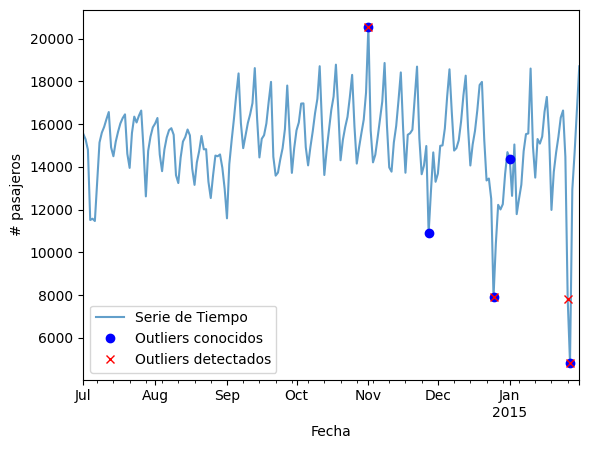

In [9]:
outliers = outliers_zscore(tx_diaria, umbral=2.5)
print(outliers)
graficar_outliers(tx_diaria, fechas, outliers)

En este caso detectamos 4 "outliers" pero 2 de ellos son prácticamente el mismo (enero 26 y 27).

Podemos ver que este método permite detectar "outliers" pero en este caso su desempeño es peor comparado con el método de Tukey. Esto se debe a que la distribución de las observaciones no es Normal o Gaussiana:

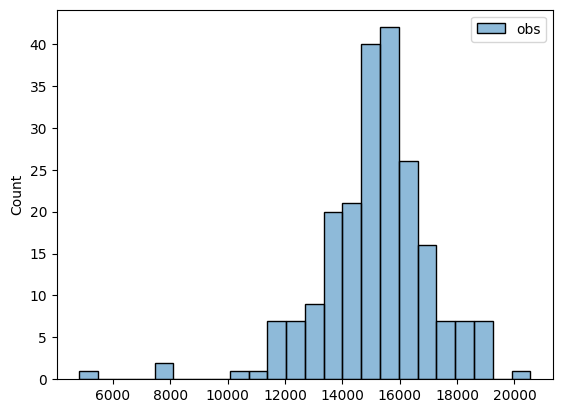

In [10]:
sns.histplot(tx_diaria);

Y además, la misma presencia de valores extremos afecta el cálculo de la media y de la desviación lo que a su vez afecta el cálculo de los puntajes z. Y esto da como resultado por ejemplo el efecto de tener dos "outliers" muy cercanos (enero 26 y 27 de 2015).

## 5. Aspectos a tener en cuenta

En últimas se sugiere usar el método de *z-score* cuando estamos seguros de que los datos tienen una distribución Normal o Gaussiana y de que los valores extremos no afectan la forma de esta distribución.

Si los valores extremos están demasiado alejados de la distribución o si esta no es Normal/Gaussiana lo más recomendable es usar el método de Tukey que es más robusto frente a estas dos situaciones.